In [12]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

DATA_DIR = '../attack_pose_data/'
EXCEL_DATA_DIR = '../attack_pose_data/DATASETS/'

In [13]:
MAPPINGS = json.load(open(DATA_DIR+'translation_mappings.json'))

df1 = pd.read_excel(EXCEL_DATA_DIR + 'Techniek_aanval_met_sprong_Ref_POSE_tabel.xlsx', index_col=0)
df1.rename(columns=MAPPINGS, inplace=True)
df2 = pd.read_excel(EXCEL_DATA_DIR + 'GX010044_Clip_6_POSE_tabel.xlsx', index_col=0)
df2.rename(columns=MAPPINGS, inplace=True)

df1.head()
df2.head()

,video_path,frame_number,person_id,nose_x,nose_y,nose_p,left_eye_x,left_eye_y,left_eye_p,right_eye_x,...,frame_file_path,hit_frame,min_wrist_y,phase,handedness,runup,jump_angle,position_to_ball,hit_arm_angle,fps
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,/content/drive/MyDrive/POSE_VOLLEYBAL/OUTPUT/G...,0,1,1041,1141,0.957478,1047,1135,0.477825,1028,...,/content/drive/MyDrive/POSE_VOLLEYBAL/OUTPUT/G...,0,1373,run-up,NaN,Rechterpas,NaN,NaN,NaN,59
1,/content/drive/MyDrive/POSE_VOLLEYBAL/OUTPUT/G...,1,1,1041,1141,0.957289,1047,1135,0.478524,1028,...,/content/drive/MyDrive/POSE_VOLLEYBAL/OUTPUT/G...,0,1373,run-up,NaN,NaN,NaN,NaN,NaN,59
2,/content/drive/MyDrive/POSE_VOLLEYBAL/OUTPUT/G...,2,1,1047,1142,0.949421,1052,1139,0.465829,1034,...,/content/drive/MyDrive/POSE_VOLLEYBAL/OUTPUT/G...,0,1380,run-up,NaN,NaN,NaN,NaN,NaN,59
3,/content/drive/MyDrive/POSE_VOLLEYBAL/OUTPUT/G...,3,1,1051,1143,0.944460,1055,1137,0.463315,1038,...,/content/drive/MyDrive/POSE_VOLLEYBAL/OUTPUT/G...,0,1383,run-up,NaN,NaN,NaN,NaN,NaN,59
4,/content/drive/MyDrive/POSE_VOLLEYBAL/OUTPUT/G...,4,1,1056,1148,0.955632,1063,1140,0.485472,1043,...,/content/drive/MyDrive/POSE_VOLLEYBAL/OUTPUT/G...,0,1382,run-up,NaN,NaN,NaN,NaN,NaN,59


### aggregate dataframe given original and target fps -- single numeric column

In [14]:
def aggregate_numeric_column(df, column_name, original_fps, target_fps):
    """
    Aggregates a single numeric column in a DataFrame based on video frame rates.
    
    Parameters:
    - df: DataFrame containing the video data.
    - column_name: The name of the numeric column to aggregate.
    - original_fps: The original frame rate of the video data.
    - target_fps: The target frame rate for aggregation.
    
    Returns:
    - A DataFrame with the aggregated column.
    - A dictionary mapping the original index to the new index.
    """
    # Ensure the column exists in the DataFrame
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame.")
    
    # Calculate the number of frames to aggregate to match the target frame rate
    factor = original_fps / target_fps
    if factor < 1:
        raise ValueError("Target FPS must be less than or equal to original FPS.")
    
    index_mapping = dict(zip(df.index, df.index // factor))

    # Aggregate the specified column
    aggregated_series = df[column_name].groupby(df.index // factor).mean()
    
    # Create a new DataFrame to return
    aggregated_df = pd.DataFrame(aggregated_series, columns=[column_name])

    return aggregated_df, index_mapping

def aggregate_all_numeric_columns(df, original_fps, target_fps):
    """
    Aggregates all numeric columns in a DataFrame based on video frame rates.
    
    Parameters:
    - df: DataFrame containing the video data.
    - original_fps: The original frame rate of the video data.
    - target_fps: The target frame rate for aggregation.
    
    Returns:
    - A DataFrame with the aggregated columns (returns only numeric columns).
    - A dictionary mapping the original index to the new index.
    """
    aggregated_dfs = []
    index_mappings = []
    
    for column_name in df.select_dtypes(include=[np.number]).columns:
        # if df[column_name].dtype == np.float64:
        aggregated_df, index_mapping = aggregate_numeric_column(df, column_name, original_fps, target_fps)
        aggregated_dfs.append(aggregated_df)
        index_mappings.append(index_mapping)
    
    return pd.concat(aggregated_dfs, axis=1), index_mappings


def aggregate_phases(df, original_fps, target_fps):
    def aggfunc(group):
        if 'attack' in group.values:
            return 'attack'
        else:
            # Compute the mode with pandas.Series.mode, which handles non-numeric data
            mode_values = group.mode()
            return mode_values.iloc[0] if not mode_values.empty else None
        
    factor = original_fps / target_fps
    if factor < 1:
        raise ValueError("Target FPS must be less than or equal to original FPS.")
    
    df['index'] = df.index // factor
        
    return df.groupby('index')['phase'].agg(aggfunc)


#### check for single column

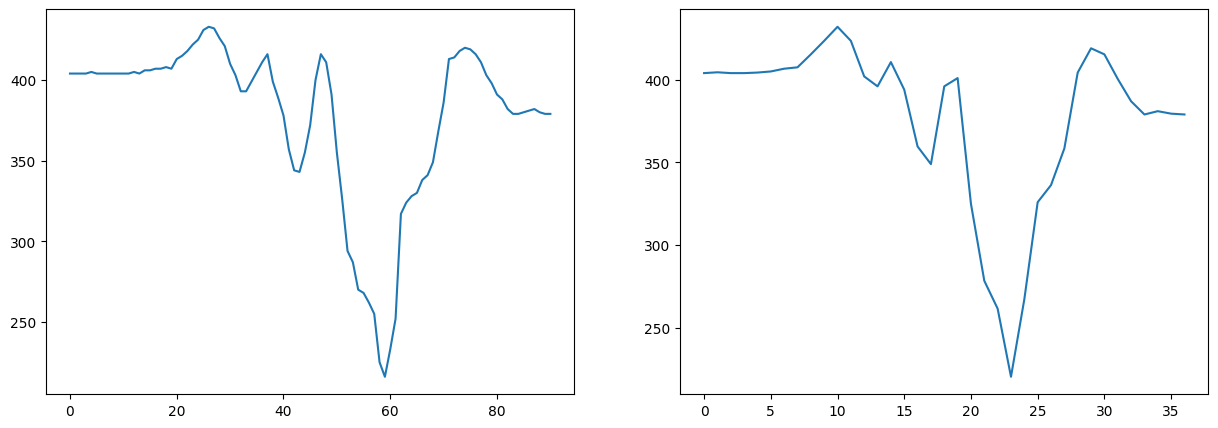

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
df, i= aggregate_numeric_column(df1, 'right_elbow_y', 30, 12)
ax[0].plot(df1.index, df1['right_elbow_y'])
ax[1].plot(df.index, df['right_elbow_y'])

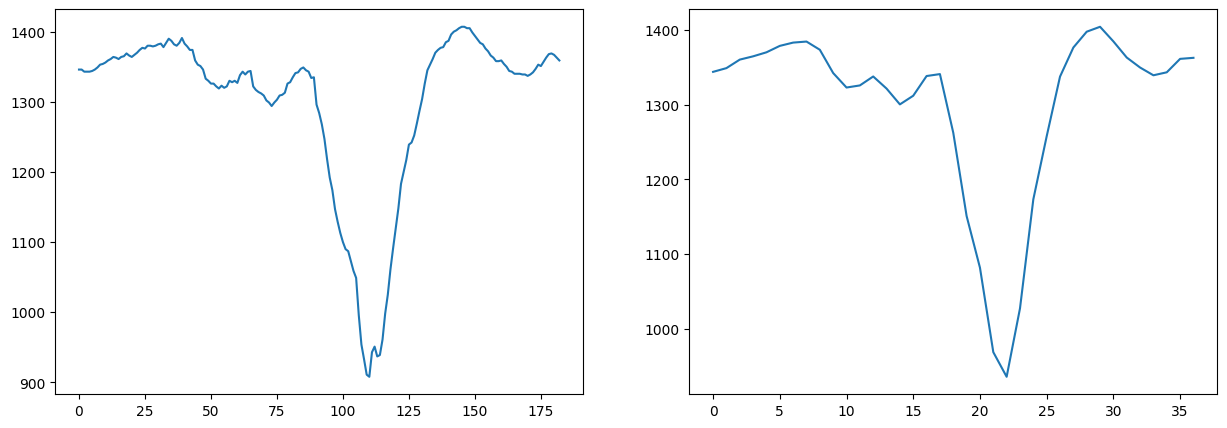

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
df, i = aggregate_numeric_column(df2, 'right_elbow_y', 60, 12)
ax[0].plot(df2.index, df2['right_elbow_y'])
ax[1].plot(df.index, df['right_elbow_y'])

#### check for entire dataframe aggregation

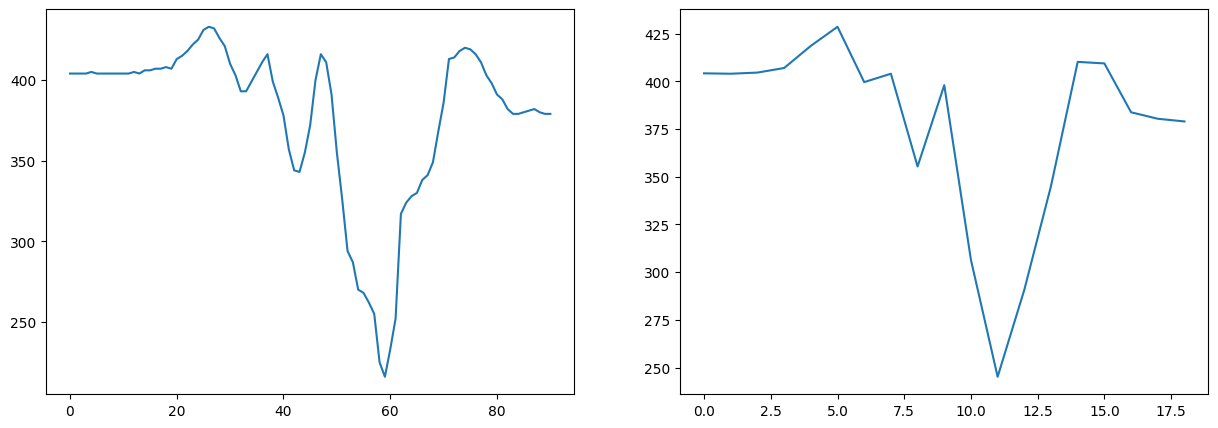

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
df, i = aggregate_all_numeric_columns(df1, 60, 12)
ax[0].plot(df1.index, df1['right_elbow_y'])
ax[1].plot(df.index, df['right_elbow_y'])

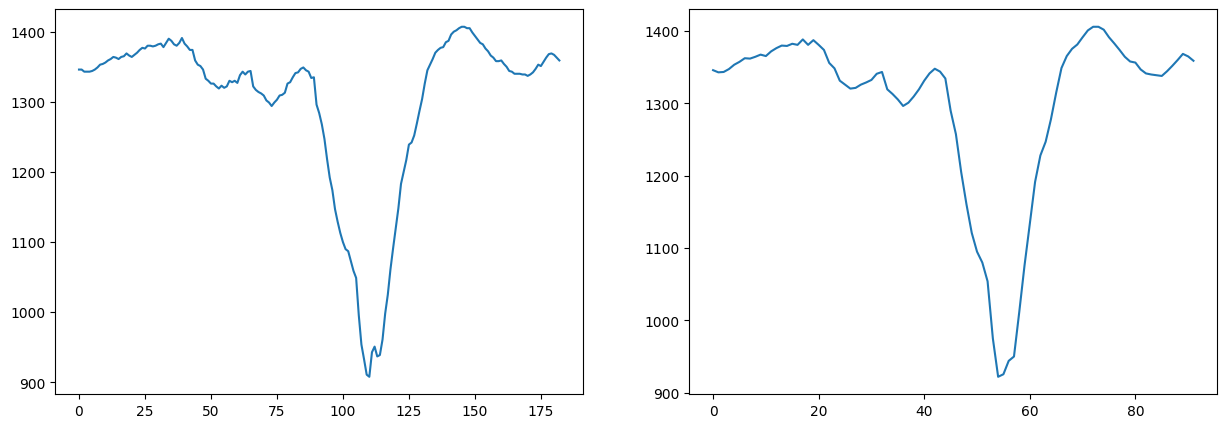

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
df, i = aggregate_all_numeric_columns(df2, 60, 30)
ax[0].plot(df2.index, df2['right_elbow_y'])
ax[1].plot(df.index, df['right_elbow_y'])

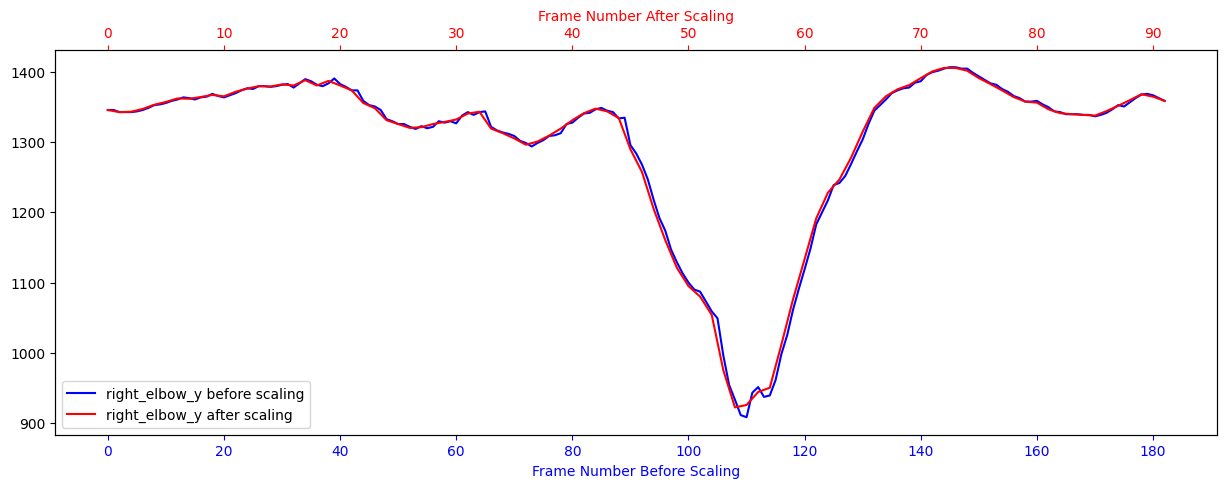

In [19]:
fig, ax1 = plt.subplots(figsize=(15, 5))

line1, = ax1.plot(df2.index, df2['right_elbow_y'], label='right_elbow_y before scaling', color='b')
ax1.tick_params(axis='x', colors='b')
ax1.set_xlabel('Frame Number Before Scaling', color='b')
ax1.set_xticks(np.arange(0, len(df2.index), 20))

# Create a second x-axis that shares the same y-axis
ax2 = ax1.twiny()
line2, = ax2.plot(df.index, df['right_elbow_y'], label='right_elbow_y after scaling', color='r')
ax2.set_xlabel('Frame Number After Scaling', color='r')
ax2.tick_params(axis='x', colors='r')
ax2.set_xticks(np.arange(0, len(df.index), 10))

plt.legend(handles=[line1, line2], loc='lower left')
plt.show()